In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

from utils import *
from usad import *

import torch.utils.data as data_utils

import sklearn.metrics
from sklearn.metrics import roc_curve,roc_auc_score

from datetime import datetime

import sys
import argparse

In [24]:
def config_args():
    parser = argparse.ArgumentParser(description='DeepAnt')
    
    parser.add_argument('--dataset', type=str, default='SWAT', help='dataset name')

    parser.add_argument('--epochs', type=int, default=40, help='number of epochs')
    parser.add_argument('--batch_size', type=int, default=64, help='number of batch')
    parser.add_argument('--hidden_size', type=int, default=20, help='number of hidden')

    parser.add_argument('--window_size', type=int, default=100, help='window size for data loader')

    parser.add_argument('--id', type=str, default='', help='pretrained model id')

    args = parser.parse_args()
    
    return args

In [25]:
def dataloader(dataset, window_size):
    if dataset == 'SWAT':
        df = pd.read_csv('./data/SWAT/test.csv', header=0, low_memory=False)
        window_data = df.values[np.arange(window_size)[None, :] + np.arange(df.shape[0] - window_size)[:, None]]

        labels = pd.read_csv('./data/SWAT/labels.csv', header=0, low_memory=False)
        labels = labels['0'].to_list()

        
        return df, window_data, labels
    
    elif dataset == 'MACHINE':
        df = pd.read_csv('./data/MACHINE/test.csv', header=0, low_memory=False)
        window_data = df.values[np.arange(window_size)[None, :] + np.arange(df.shape[0] - window_size)[:, None]]

        labels = pd.read_csv('./data/MACHINE/labels.csv', header=0, low_memory=False)
        labels = labels['attack'].to_list()
        
        return df, window_data, labels
        
    elif dataset == 'PRESTO':
        df = pd.read_csv('./data/PRESTO/test.csv', header=0, low_memory=False)
        df = df.reset_index(drop=True)
        window_data = df.values[np.arange(window_size)[None, :] + np.arange(df.shape[0] - window_size)[:, None]]

        labels = pd.read_csv('./data/PRESTO/labels.csv', header=0, low_memory=False)
        labels = labels['attack'].to_list()

        return df, window_data, labels
        
    else:
        print('dataset X')

In [27]:
def ROC(y_test,y_pred):
    fpr, tpr, tr = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    idx = np.argwhere(np.diff(np.sign(tpr - (1 - fpr)))).flatten()

    return tr[idx]

In [44]:
def cal_metrics(labels, outputs, window_size, threshold=None):

    # original label
    windows_labels=[]
    for i in range(len(labels) - window_size):
        windows_labels.append(list(np.int_(labels[i : i + window_size])))

    y_test = [ 1.0 if (np.sum(window) > 0) else 0 for window in windows_labels ]
    
    # predicted output
    y_pred = np.concatenate([torch.stack(outputs[:-1]).flatten().detach().cpu().numpy(),
                              outputs[-1].flatten().detach().cpu().numpy()])

    # threshold
    if threshold is None:
        threshold = ROC(y_test, y_pred)

    y_pred_ = np.zeros(len(y_pred))
    y_pred_ = [1.0 if (i >= threshold) else 0.0 for i in y_pred]

    print('threshold :', threshold)
    print(sklearn.metrics.classification_report(y_test, y_pred_))
    return y_pred_

In [66]:
def plot_anomaly_features(data, pred, labels, window_size, ylim_margin=0.05):
    """
    data: (num_samples, num_features) pandas DataFrame
    pred: 모델이 anomaly라고 예측한 1차원 리스트 (1: anomaly, 0: 정상)
    labels: 실제 anomaly 라벨이 포함된 1차원 리스트 (1: anomaly, 0: 정상)
    window_size: 데이터를 삭제할 윈도우 크기
    ylim_margin: y축 범위 조정 비율 (0.05 = 5%)
    """
    num_samples = len(data)
    num_features_total = len(data.columns)
    
    # 모든 feature 선택
    selected_features = data.columns
    
    # 서브플롯 생성 (특성의 수만큼 서브플롯)
    fig, axs = plt.subplots(num_features_total, 1, figsize=(15, 2 * num_features_total), sharex=True)
    
    # 시간 인덱스 문자열을 정수로 변환
    time_indices = np.arange(num_samples)
    
    # 각 특성에 대해 서브플롯을 생성
    for i, feature_name in enumerate(selected_features):
        feature_data = data[feature_name]
        trimmed_data = feature_data[window_size:]
        trimmed_labels = labels[window_size:]
        trimmed_pred = pred[window_size:]
        
        trimmed_data = trimmed_data
        trimmed_labels = trimmed_labels
        trimmed_pred = trimmed_pred
        
        time = time_indices[:len(trimmed_data)]
        
        # 서브플롯 설정
        # 데이터 라인을 맨 뒤로 설정
        axs[i].plot(time, trimmed_data, color='black', label='Data', zorder=1)
        
        # 실제 anomaly 부분을 중간에 설정
        actual_anomaly_indices = [j for j in range(len(trimmed_labels)) if trimmed_labels[j] == 1]
        if actual_anomaly_indices:
            axs[i].scatter(time[actual_anomaly_indices], [trimmed_data.iloc[j] for j in actual_anomaly_indices], 
                           color='red', label='Actual Anomalies', marker='o', s=2, zorder=2)
        
        # 모델이 anomaly라고 예측한 부분을 맨 위로 설정
        predicted_anomaly_indices = [j for j in range(len(trimmed_pred)) if trimmed_pred[j] == 1]
        if predicted_anomaly_indices:
            axs[i].scatter(time[predicted_anomaly_indices], [trimmed_data.iloc[j] for j in predicted_anomaly_indices], 
                           color='blue', label='Predicted Anomalies', marker='o', s=1.5, zorder=3)
        
        axs[i].set_ylabel(f'Feature: {feature_name}')
        axs[i].legend(loc='upper right', bbox_to_anchor=(1.17, 1), frameon=False)
        
        # y축 범위를 자동으로 조정
        min_data = trimmed_data.min()
        max_data = trimmed_data.max()
        range_data = max_data - min_data
        margin = ylim_margin * range_data
        axs[i].set_ylim(min_data - margin, max_data + margin)
    
    axs[-1].set_xlabel("Time")
    plt.tight_layout()
    plt.show()


---

In [30]:
sys.argv = [''] 
sys.argv += ['--dataset', 'PRESTO', '--epochs', '40', '--batch_size', '64', 
             '--window_size', '100', '--id', '06092024_042910']

In [31]:
args = config_args()

In [32]:
df, dataset, labels = dataloader(args.dataset, args.window_size)
print('test data : ', dataset.shape)

test data :  (69600, 100, 8)


In [33]:
w_size = dataset.shape[1] * dataset.shape[2]
z_size = dataset.shape[1] * args.hidden_size

In [34]:
test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
        torch.from_numpy(dataset).float().view(([dataset.shape[0], w_size]))
) , batch_size=args.batch_size, shuffle=False, num_workers=0)

In [35]:
model_path = f'results/{args.dataset}/{args.id}.pth'
checkpoint = torch.load(model_path)

model = UsadModel(w_size, z_size)
model = to_device(model, device)

model.encoder.load_state_dict(checkpoint['encoder'])
model.decoder1.load_state_dict(checkpoint['decoder1'])
model.decoder2.load_state_dict(checkpoint['decoder2'])
print(model)

UsadModel(
  (encoder): Encoder(
    (linear1): Linear(in_features=800, out_features=400, bias=True)
    (linear2): Linear(in_features=400, out_features=200, bias=True)
    (linear3): Linear(in_features=200, out_features=2000, bias=True)
    (relu): ReLU(inplace=True)
  )
  (decoder1): Decoder(
    (linear1): Linear(in_features=2000, out_features=200, bias=True)
    (linear2): Linear(in_features=200, out_features=400, bias=True)
    (linear3): Linear(in_features=400, out_features=800, bias=True)
    (relu): ReLU(inplace=True)
    (sigmoid): Sigmoid()
  )
  (decoder2): Decoder(
    (linear1): Linear(in_features=2000, out_features=200, bias=True)
    (linear2): Linear(in_features=200, out_features=400, bias=True)
    (linear3): Linear(in_features=400, out_features=800, bias=True)
    (relu): ReLU(inplace=True)
    (sigmoid): Sigmoid()
  )
)


In [36]:
outputs = testing(model, test_loader, 0.5, 0.5)

In [45]:
y_pred = cal_metrics(labels, outputs, args.window_size)

threshold : [4.866285e-06]
              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96     66406
         1.0       0.36      0.92      0.52      3194

    accuracy                           0.92     69600
   macro avg       0.68      0.92      0.74     69600
weighted avg       0.97      0.92      0.94     69600



In [46]:
y_pred = cal_metrics(labels, outputs, args.window_size, threshold=0.000005)

threshold : 5e-06
              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98     66406
         1.0       0.50      0.91      0.65      3194

    accuracy                           0.95     69600
   macro avg       0.75      0.93      0.81     69600
weighted avg       0.97      0.95      0.96     69600



In [47]:
y_pred = cal_metrics(labels, outputs, args.window_size, threshold=0.0000055)

threshold : 5.5e-06
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     66406
         1.0       0.95      0.85      0.90      3194

    accuracy                           0.99     69600
   macro avg       0.97      0.92      0.95     69600
weighted avg       0.99      0.99      0.99     69600



---

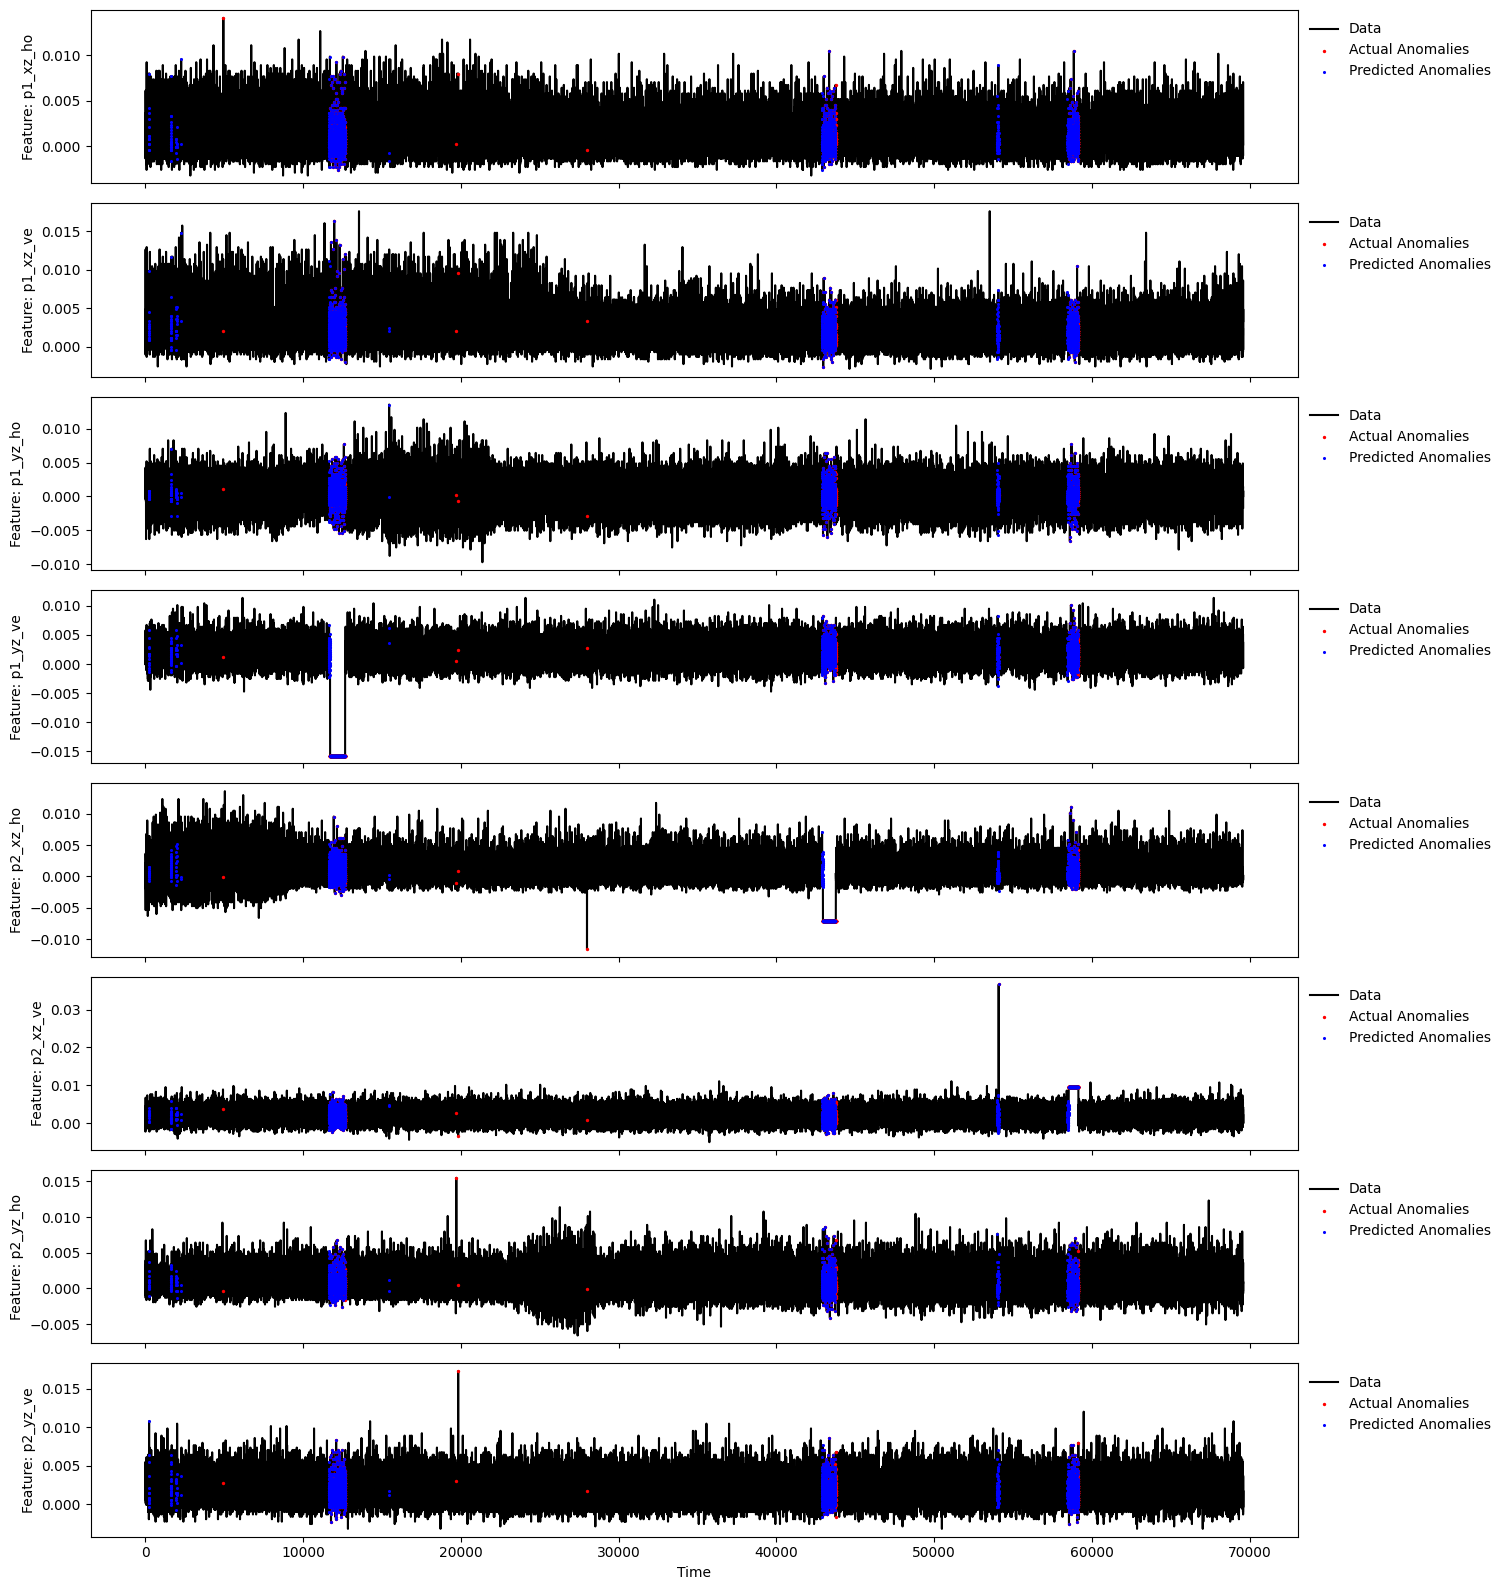

In [65]:
plot_anomaly_features(df, y_pred, labels, args.window_size)